# Introduction to Prophet
<img src=images/logo.png align='right' width=200>

## Goal

The goal of this notebook is to introduce Prophet from Facebook. It is a procedure for forecasting time series data that works by explicitly modeling trends, seasonalities and holiday effects, making it especially suitable for business applications.

## Program

- [About Prophet](#ap)
- [Forecasting with Prophet](#fwp)
- [Plotting with Prophet](#pwp)
    - [Assignment](#as1)
- [Model evaluation with Prophet](#mewp)
- [Tracking trend change points](#ttcp)
- [Multiplicative Seasonality and Model Selection](#msms)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from prophet import Prophet

%matplotlib inline
plt.rcParams["font.size"] = 14
plt.rcParams['figure.figsize'] = (20.0, 10.0)

<a id='ap'></a>
## About Prophet

<!-- [Installation guide for Prophet](https://facebook.github.io/prophet/docs/installation.html#python)

You may also want to install `plotly` (4.0 or above) and `ipywidgets` for interactive plots. -->

<a href="https://facebookincubator.github.io/prophet/">
<img src='images/prophet.png' align='center' style="width:300px"></a> 

Prophet is a libary for forecasting time series data. It was released by Facebook’s Core Data Science team (Feb 23, 2017 in [github](https://github.com/facebookincubator/prophet)); models are "fit" with [Stan](http://mc-stan.org/) and you can read the paper [here](https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf).

### How Prophet works

Prophet uses an additive regression model with the following main components:

* a piecewise linear / logistic growth curve trend
* automatically detects changes in trends by selecting change points
* a *yearly* seasonal component (using Fourier series)
* a *weekly* seasonal component (using dummy variables)
* user provided list of important holidays *(optional)*


**Pros:** 
- Highly automated and simple to use. 
- Does not require extensive preprocessing and domain knowledge. 
- Robust to missing data, outliers and dramatic changes. 
- Measures explainable and quantifiable effects. 
- Can be easily used to detect outliers and trend change points. 
- Typically outperforms many custom models.

**Cons:** 
- Is a bit of a black box. 
- Still in development and some features are still missing. 
- Less customization of the model.

<a id='fwp'></a>
## Forecasting with Prophet

To demonstrate prophet we shall use the dataset containing total monthly passenger traffic at Schiphol airport between 1999 and 2019 from [Statistics Netherlands (CBS)](https://opendata.cbs.nl/statline/#/CBS/en/dataset/37478ENG/table?dl=6F18). Each datapoint indicates the total number of passengers traveled via Schiphol in millions in each particular month.

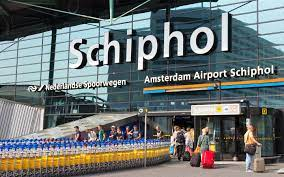

In [ ]:
schiphol = pd.read_csv('data/schiphol_passengers.csv', index_col='date', parse_dates=True)
schiphol.index.freq = 'MS'
schiphol.head()

Prophet expects a `ds` column with timestamps and he variable of interest should be called `y`.

In [ ]:
schiphol = (schiphol
            .rename(columns={'total_passengers': 'y'})
            .assign(y = lambda df: df['y']/1000000,  #the variable of interest should be called 'y' for Prophet
                   ds = lambda df: df.index)  #Prophet needs a 'ds' column with timestamps
           )
schiphol.head()

In [ ]:
schiphol_train = schiphol.loc[:'2017 Jan']
schiphol_test = schiphol.loc['2017 Jan':]

In [ ]:
fig, ax = plt.subplots(figsize=(18,5))
schiphol_train['y'].plot(ax=ax);
schiphol_test['y'].plot(ax=ax, c='g');

### Fitting the model

To fit the model we must first instantiate a new `Prophet` object.  

If Prophet does not detect a certain type of seasonality - it turns it off. So if you know this type should actually be there - you need to specify it.

In [ ]:
model = Prophet()

##if we want to explicitly set seasonality:
#model = Prophet(yearly_seasonality=True, daily_seasonality=False)

Once the model has been initiaed you can call its `fit` method and pass in the historical dataframe.

In [ ]:
model.fit(schiphol_train);

Predictions are then made on a dataframe with a column `ds` containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method `.make_future_dataframe()`. By default it will also include the dates from the history, so we will see the model fit as well.

Prophet expects daily data by default - remember to specify if you have a different format

In [ ]:
future = model.make_future_dataframe(periods=35, freq='MS') 
future.tail()

The `predict` method will assign each row in `future` a predicted value which it names `yhat`.  If you pass in historical dates, it will provide an in-sample fit. 

The `forecast` object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals. 

By default the width of the uncertainty intervals (confidence interval) is set to 80%. It is a model paramter that can be set, e.g. `Model(interval_width=0.95)`.

<!-- Prophet estimates the uncertainty intervals using Monte Carlo simulation. The `uncertainty_samples` parameter controls the simulation. It is the number of samples used to estimate the uncertainty interval (by default 1000). It is a model paramter that can be set, e.g. `Model(uncertainty_samples=100)`. -->

In [ ]:
forecast = model.predict(future)
print(forecast.shape)
forecast.head()

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

<a id='pwp'></a>
## Plotting with Prophet

### Plotting the forecast

Prophet has its own plotting functionality, which is compatible with Matplotlib. You can plot the forecast by calling the `.plot()` method and passing in your forecast dataframe.

Black dots indicate the real data points. Dark blue line shows the model fit with light blue area indicating lower to upper prediction bounds.

In [ ]:
model.plot(forecast, figsize=(18,7));
plt.xticks(rotation=25);

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need the `ipywidgets` package.

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

Let's have a closer look at the prediction area and compare it to the actual  test set values:

In [ ]:
fig, ax = plt.subplots()
model.plot(forecast, ax=ax);
schiphol_test['y'].plot(ax=ax, c='green')
plt.xticks(rotation=25)
plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2019-12-01')); # to zoom into a region

Predictions look quite good, especially for fall and winter months, with a bit of underestimation for the summer peaks.


### Plotting the components

If we want a more customized plot, we can simply get the necessary columns from the *forecast* dataframe and plot them as we usually would do with Pandas:

In [ ]:
pltr = (forecast
         .set_index(schiphol.index)
        )

fig, ax = plt.subplots(figsize=(18,6))
schiphol['y'].plot(ax=ax);
pltr[['trend','yearly']].plot(ax=ax);
ax.legend(["y_real", "trend", "yearly seasonality"], prop={'size': 16});

<a id='as1'></a>
## Assignment: Detecting Outliers

Identify and highlight on the plot the *training set* points that lie outside of the confidence boundaries of our Prophet model

*HINT:* Create a new variable that has the real *y values* when it is an outlier and a missing value (np.nan) otherwise. Then plot it alongside Prophet's plot. Make sure the index of the new dataframe is the timestamps.

In [ ]:
# %load answers/prophet_outliers.py





We can also plot components of Prophet's forecast using `model.plot_components(forecast)`. Note how this also includes confidence boundaries for the future trend (in our case, 2017 onwards):

In [ ]:
model.plot_components(forecast)
plt.xticks(rotation=25);

In [ ]:
plot_components_plotly(model, forecast)

<a id='mewp'></a>
## Model Evaluation with Prophet

Since Prophet provides the $\hat{y}$ column, we can compare it with the actual test data and calculate the usual metrics such as MAE or RMSE, as we would normally do with our custom models

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

y_pred = forecast.iloc[-36:]['yhat']
y_test = schiphol_test['y']
y_test_mean = round(y_test.mean(),2)

MAE = round(mean_absolute_error(y_test, y_pred),2)
MSE = round(mean_squared_error(y_test, y_pred),2)
RMSE = round(np.sqrt(MSE),3)
MAPE = round(mean_absolute_percentage_error(y_test, y_pred)*100,2)

print(f'MAE: {MAE}, MAPE: {MAPE}%')

print(f'RMSE: {RMSE}. It is {round(100*RMSE/y_test_mean,1)}% of the test set average value {y_test_mean}')

Luckily for us, Prophet comes with its own model diagnostics functionality. It can actually do much more than just MSE on the test set. Most notably, it allows model evaluation with cross-validation - evaluate the model on several sections of our time series. This can give an even better idea of the model's predictive power.

<img src='images/prophet_cv.png' style="width:500px"></a> 

Various cutoff points are selected in the history, and for each of them the model is fitted using data only up to that cutoff point. The forecasted values are then compared to the actual values. 

In [ ]:
from prophet.diagnostics import cross_validation

First we need to set some parameters for `cross_validation`:

As we are working with monthly data it is better to specify the cutoff periods we will use. 

In [ ]:
schiphol_train['ds'].min(), schiphol_train['ds'].max()

In [ ]:
# Cutoffs - we will train on data up until the cutoff points
# i.e. 5 year inital period, then every 2 years
cutoffs = pd.date_range(start='2004-01-01', end='2016-01-01', freq='2Y')
cutoffs

However, it would also be possible to specify an initial training period and the subsequent spacing between cutoff dates.

In [ ]:
# #Initial - the size of the initial training period (3 * horizon by default)
# initial = str(5*365)+" days"
# initial

In [ ]:
# #Period - the spacing between cutoff dates - every X days  (0.5 * horizon by default)
# period = str(2*365)+" days"
# period

The horizon specifies how far into the future we want to predict.

In [ ]:
#Horizon - how far out to forecast for each period
horizon = str(365)+" days"
horizon

In [ ]:
#performing cross validation

# Using cutoffs
df_cv = cross_validation(model, cutoffs=cutoffs, horizon=horizon)

# Using inital & period
# df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)

Let's have a look at the results of cross validation:

In [ ]:
df_cv

In [ ]:
df_cv.resample('Y', on='ds').count()

Metrics for the cross-validation predictions are computed for different horizon windows:

In [ ]:
from prophet.diagnostics import performance_metrics
performance_metrics(df_cv, rolling_window = 0.1)

The size of the windows (number of simulated forecast points) is determined by the `rolling_window` argument.

- The default of `rolling_window=0.1` will incorporate 10% more predictions in each window. 
- `rolling_window=1` will compute the metric across all simulated forecast points. 

To comprehend the cross validation results it can be helpful to make a plot.

In [ ]:
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric='rmse');

In [ ]:
#mape - mean absolute percentage error
plot_cross_validation_metric(df_cv, metric='mape');

<a id='ttcp'></a>
## Tracking Trend Change Points

Often it is valuable to identify points in time at which the growth rate over time changes and breaks in the trend happen. Prophet has some useful tools to assist us with this.

Let's first have a look at our dataset and the trends in it again:

In [ ]:
schiphol['y'].plot(figsize=(18,6));

How many change points do you think there are in the data? Which are easier to identify?

Now let's consult Prophet:

In [ ]:
from prophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
c_points = add_changepoints_to_plot(fig.gca(),model, forecast)

Change point detection with Prophet is not only simple, but would typically outperform many good custom models. It can serve as a handy analytical tool to identify and better understand key periods of the time series.

<a id='msms'></a>
## Multiplicative Seasonality and Model Selection

While it may feel like Prophet does all the work for you, there are some important parameters that you can change to create a better model. For instance, you can manually set the types of seasonality that you expect in the data (even though Prophet can also do this automatically). You can also choose to not have constant seasonality over time - by default Prophet will assume fixed seasonality.

Let's inspect our Prophet model once again and pay a closer attention to the seasonal cycles:

In [ ]:
model.plot(forecast, figsize=(18,7));
plt.xticks(rotation=25);
plt.xlim(pd.Timestamp('1999-01-01'), pd.Timestamp('2017-01-01'));

We can notice that our seasonal cycles are a bit too large for the beginning and a bit too small for the latest data points. This could be a likely sign of *Multiplicative Seasonality*. By setting `seasonality_mode='multiplicative'` we can allow Prophet to fit a model with growing (or shrinking) seasonal cycles over time.

In [ ]:
model2 = Prophet(seasonality_mode='multiplicative')
model2.fit(schiphol_train);


future2 = model2.make_future_dataframe(periods=35, freq='MS') 
forecast2 = model2.predict(future2)

fig, ax = plt.subplots()
model2.plot(forecast2, ax=ax);
plt.xticks(rotation=25);

This seems to be a much better fit! The seasonal cycles are just large enough for all moments in time. Also notice how the confidence bounds are narrower - the model is more confident about its fit and predictions now.

Ironically, a better fit does not always mean better predictions. This new model is quite confident that summer passenger traffic will be expanding more and more after 2017. This is not unreasonable given the past data. However the reality (airport capacity and environmental challenges) make the reality a bit different: 

In [ ]:
fig, ax = plt.subplots()
model2.plot(forecast2, ax=ax);
schiphol_test['y'].plot(ax=ax, c='r');
plt.xticks(rotation=25);

We actually make more errors with this new model, when making predictions into 2017-2019, even though it fits the historic data better:

In [ ]:
y_pred2 = forecast2.iloc[-36:]['yhat']


MSE2 = round(mean_squared_error(y_test, y_pred2),2)
RMSE2 = round(np.sqrt(MSE2),3)

print(f'RMSE: {RMSE2}. It is {round(100*RMSE2/y_test_mean,1)}% of the test set average value {y_test_mean}')
print(f'while previously we had RMSE={RMSE} ({round(100*RMSE/y_test_mean,1)}%)')

Note how this is not clear from cross-validated scores - they are primarily based on the historic data where *Model 2* usually does better. These scores therefore may not properly alarm us that the assumption of further expanding seasonality of *Model 2* may hinder our predictions post-2017:

In [ ]:
#performing cross validation with the new model
df_cv2 = cross_validation(model2, cutoffs=cutoffs, horizon=horizon)
# df_cv2 = cross_validation(model2, initial=initial, period=period, horizon=horizon)

In [ ]:
fig, ax = plt.subplots()
plot_cross_validation_metric(df_cv, metric='rmse', ax=ax)
plot_cross_validation_metric(df_cv2, metric='rmse', ax=ax);
plt.gca().get_lines()[3].set_color("green")
ax.legend(["", "model 1", "", "model 2"], prop={'size': 18});